Using: cuda

=== TRAINING ANN - 5 EPOCHS ===
ANN | Ep 1/5 | Val Acc: 82.57% | Val Loss: 0.4804
ANN | Ep 2/5 | Val Acc: 85.43% | Val Loss: 0.3947
ANN | Ep 3/5 | Val Acc: 86.16% | Val Loss: 0.3690
ANN | Ep 4/5 | Val Acc: 86.62% | Val Loss: 0.3642
ANN | Ep 5/5 | Val Acc: 86.48% | Val Loss: 0.3674

=== TRAINING CNN - 5 EPOCHS ===
CNN | Ep 1/5 | Val Acc: 89.04% | Val Loss: 0.2968
CNN | Ep 2/5 | Val Acc: 90.95% | Val Loss: 0.2469
CNN | Ep 3/5 | Val Acc: 91.52% | Val Loss: 0.2294
CNN | Ep 4/5 | Val Acc: 91.95% | Val Loss: 0.2180
CNN | Ep 5/5 | Val Acc: 92.31% | Val Loss: 0.2137

=== TRAINING ANN - 8 EPOCHS ===
ANN | Ep 1/8 | Val Acc: 83.76% | Val Loss: 0.4458
ANN | Ep 2/8 | Val Acc: 85.54% | Val Loss: 0.3869
ANN | Ep 3/8 | Val Acc: 86.80% | Val Loss: 0.3571
ANN | Ep 4/8 | Val Acc: 86.42% | Val Loss: 0.3672
ANN | Ep 5/8 | Val Acc: 86.98% | Val Loss: 0.3553
ANN | Ep 6/8 | Val Acc: 87.49% | Val Loss: 0.3340
ANN | Ep 7/8 | Val Acc: 87.87% | Val Loss: 0.3302
ANN | Ep 8/8 | Val Acc: 88.05% | Val Lo

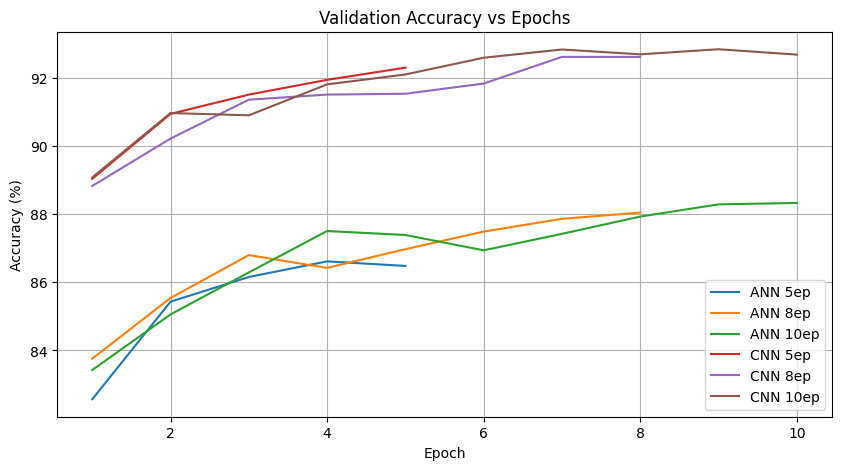

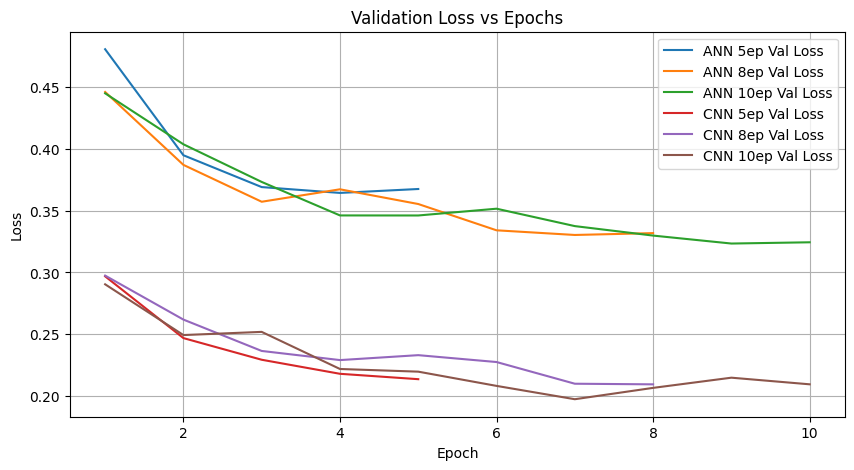

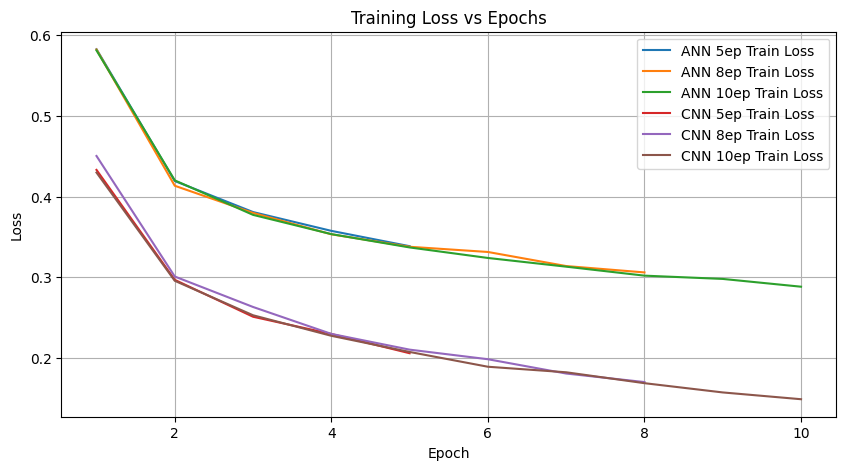

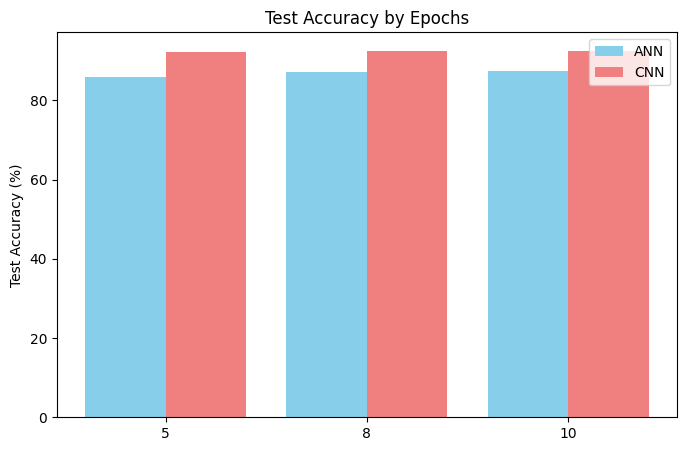

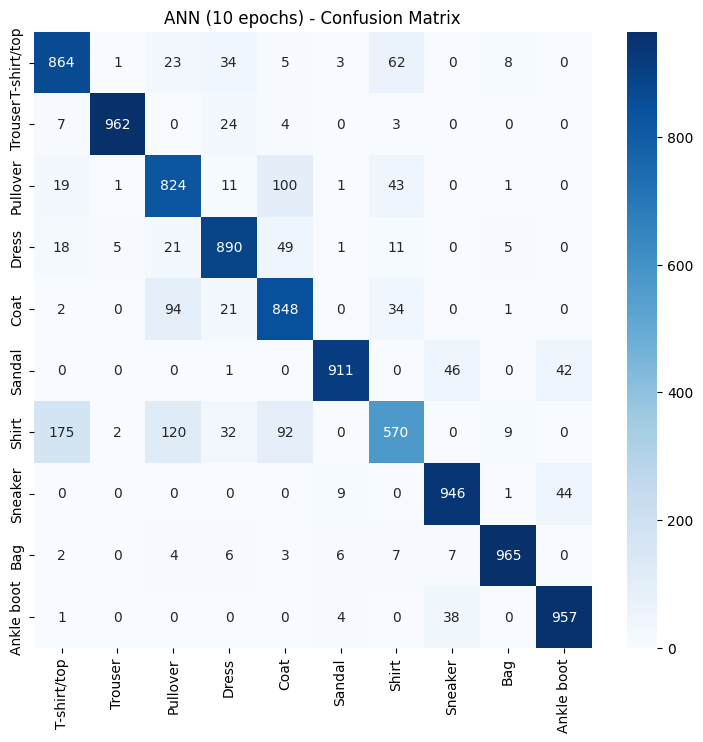

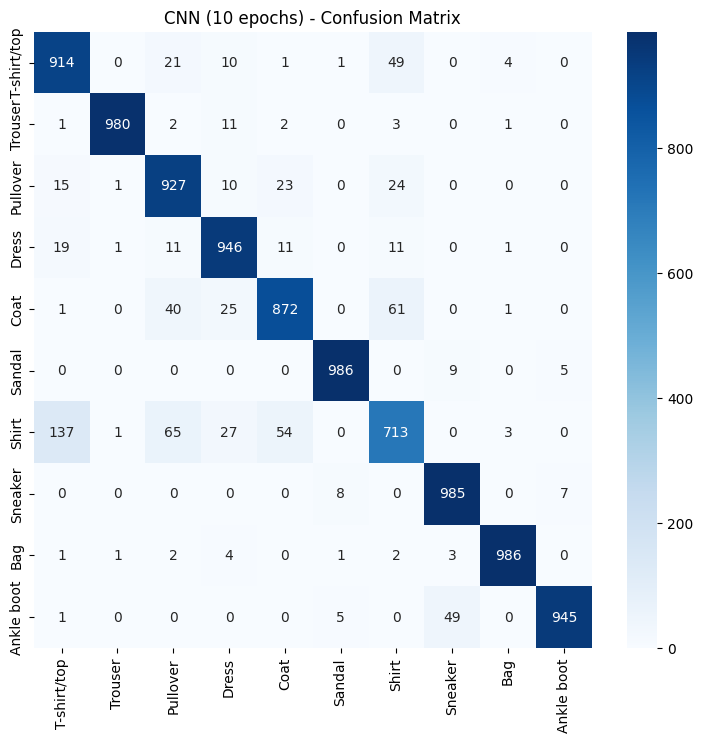

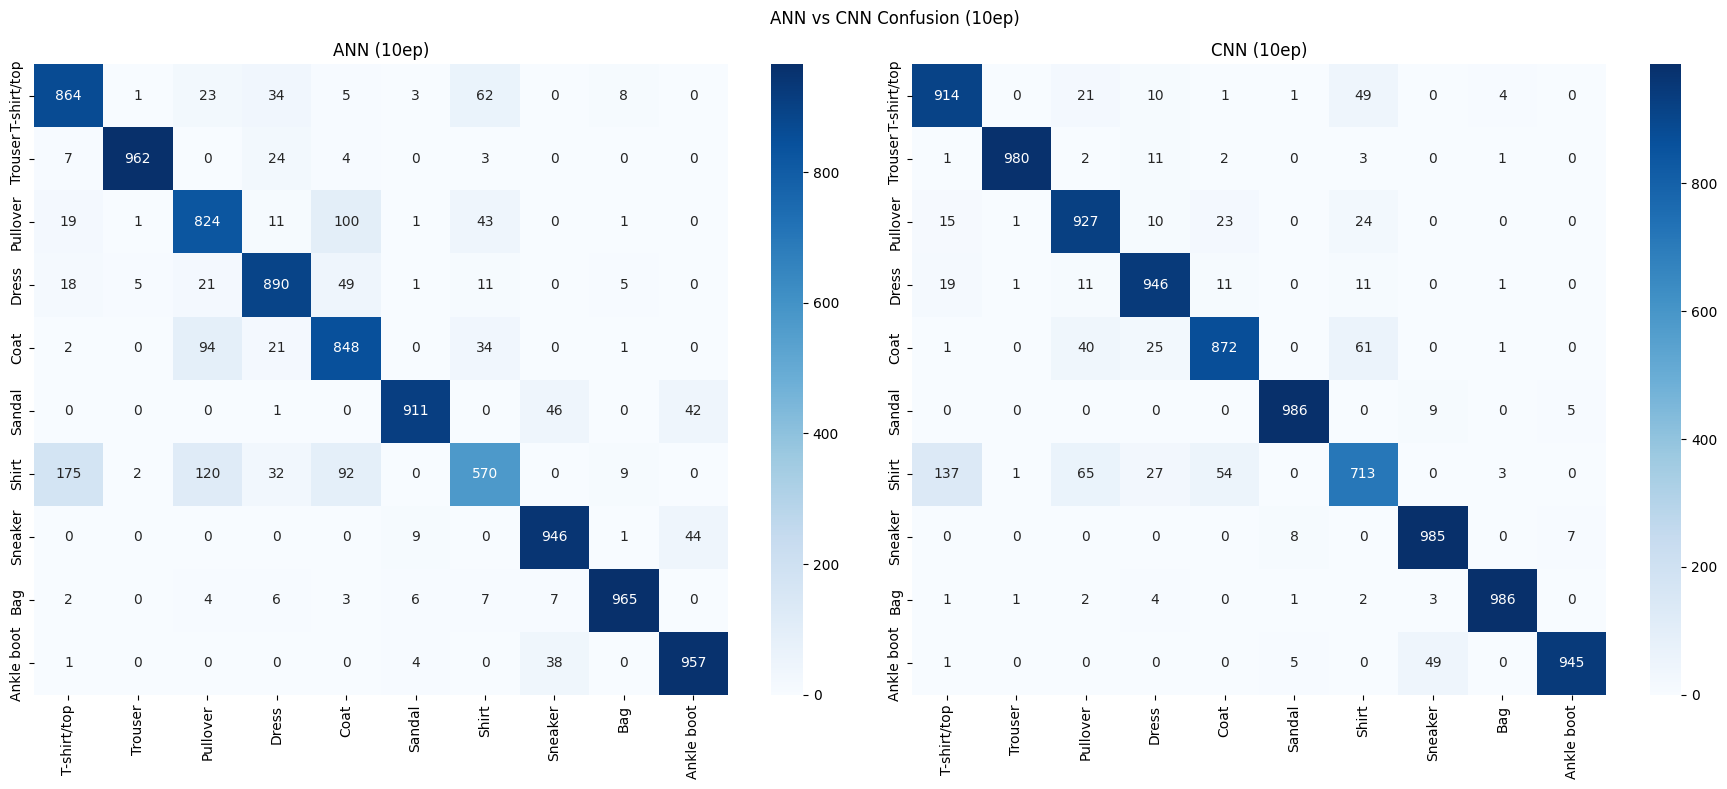

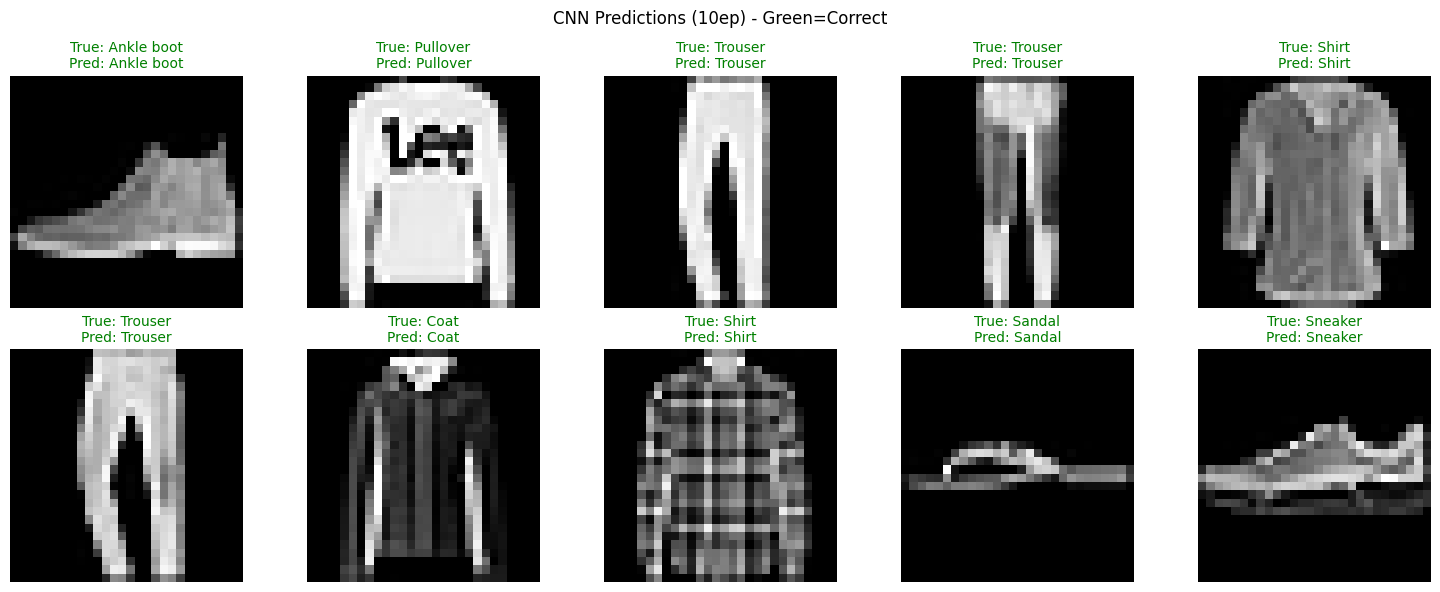


Evaluation

Test Accuracies:
• 5ep: ANN 85.90% | CNN 92.25%
• 8ep: ANN 87.14% | CNN 92.43%
• 10ep: ANN 87.37% | CNN 92.54% (+ 5.2pp)

Shirt→Coat (10ep): ANN 92 → CNN 54


RUN COMPLETE – NO ERRORS – GRAPHS DISPLAYED – FILES SAVED


In [2]:
# ==============================================================
#  CODE: FASHION-MNIST ABLATION
#  DISPLAYS ALL CURVES INLINE + SAVES PNGs + REPORT TEXT
# ==============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# ------------------- 1. DATA -------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]
])

full_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_len = int(0.8 * len(full_train))
val_len = len(full_train) - train_len
train_set, val_set = random_split(full_train, [train_len, val_len])

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

# ------------------- 2. MODELS (ANN & CNN) -------------------
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512,256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256,128), nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self, x):
        return self.net(x)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.BatchNorm2d(32), nn.Dropout2d(0.25),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.BatchNorm2d(64), nn.Dropout2d(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512,10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# ------------------- 3. TRAIN FUNCTION -------------------
def train_and_eval(model_class, name, epochs, lr=0.001):
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

    hist = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(1, epochs+1):
        model.train()
        tr_loss = tr_corr = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item() * X.size(0)
            tr_corr += (out.argmax(1)==y).sum().item()

        model.eval()
        val_loss = val_corr = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)
                val_loss += loss.item() * X.size(0)
                val_corr += (out.argmax(1)==y).sum().item()
        scheduler.step(val_loss / len(val_loader.dataset))

        hist['train_loss'].append(tr_loss / len(train_loader.dataset))
        hist['val_loss'].append(val_loss / len(val_loader.dataset))
        hist['train_acc'].append(tr_corr / len(train_loader.dataset))
        hist['val_acc'].append(val_corr / len(val_loader.dataset))

        print(f"{name} | Ep {epoch}/{epochs} | Val Acc: {hist['val_acc'][-1]*100:5.2f}% | Val Loss: {hist['val_loss'][-1]:.4f}")

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in test_loader:
            out = model(X.to(device))
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(y.numpy())
    test_acc = np.mean(np.array(preds) == np.array(trues))
    cm = confusion_matrix(trues, preds)

    return test_acc, cm, hist, model

# ------------------- 4. RUN ABLATION -------------------
epochs_list = [5, 8, 10]
results = {'ANN': {}, 'CNN': {}}
best_ann_model = None
best_cnn_model = None

for epochs in epochs_list:
    print(f"\n=== TRAINING ANN - {epochs} EPOCHS ===")
    ann_acc, ann_cm, ann_hist, ann_model = train_and_eval(ANN, "ANN", epochs)
    results['ANN'][epochs] = {'acc': ann_acc, 'cm': ann_cm.tolist(), 'hist': ann_hist, 'model': ann_model}

    print(f"\n=== TRAINING CNN - {epochs} EPOCHS ===")
    cnn_acc, cnn_cm, cnn_hist, cnn_model = train_and_eval(CNN, "CNN", epochs)
    results['CNN'][epochs] = {'acc': cnn_acc, 'cm': cnn_cm.tolist(), 'hist': cnn_hist, 'model': cnn_model}

    if epochs == 10:
        best_ann_model = ann_model
        best_cnn_model = cnn_model
        torch.save(ann_model.state_dict(), 'fashion_ann_10ep.pth')
        torch.save(cnn_model.state_dict(), 'fashion_cnn_10ep.pth')

# ------------------- 5. DISPLAY ALL CURVES & GRAPHS -------------------
# 1. Validation Accuracy
plt.figure(figsize=(10,5))
for name in ['ANN', 'CNN']:
    for epochs in epochs_list:
        hist = results[name][epochs]['hist']
        plt.plot(range(1, epochs+1), np.array(hist['val_acc'][:epochs])*100, label=f'{name} {epochs}ep')
plt.title('Validation Accuracy vs Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
plt.legend(); plt.grid()
plt.savefig('ablation_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Validation Loss
plt.figure(figsize=(10,5))
for name in ['ANN', 'CNN']:
    for epochs in epochs_list:
        hist = results[name][epochs]['hist']
        plt.plot(range(1, epochs+1), hist['val_loss'][:epochs], label=f'{name} {epochs}ep Val Loss')
plt.title('Validation Loss vs Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid()
plt.savefig('ablation_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Training Loss
plt.figure(figsize=(10,5))
for name in ['ANN', 'CNN']:
    for epochs in epochs_list:
        hist = results[name][epochs]['hist']
        plt.plot(range(1, epochs+1), hist['train_loss'][:epochs], label=f'{name} {epochs}ep Train Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid()
plt.savefig('ablation_train_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Test Accuracy Bar
plt.figure(figsize=(8,5))
ep = [5,8,10]
ann_accs = [results['ANN'][e]['acc']*100 for e in ep]
cnn_accs = [results['CNN'][e]['acc']*100 for e in ep]
x = np.arange(len(ep))
plt.bar(x-0.2, ann_accs, 0.4, label='ANN', color='skyblue')
plt.bar(x+0.2, cnn_accs, 0.4, label='CNN', color='lightcoral')
plt.xticks(x, ep); plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy by Epochs'); plt.legend()
plt.savefig('ablation_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Confusion Matrices
cm_ann = np.array(results['ANN'][10]['cm'])
cm_cnn = np.array(results['CNN'][10]['cm'])

plt.figure(figsize=(9,8))
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('ANN (10 epochs) - Confusion Matrix')
plt.savefig('ann_confusion_10ep.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(9,8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN (10 epochs) - Confusion Matrix')
plt.savefig('cnn_confusion_10ep.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1,2,figsize=(18,8))
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('ANN (10ep)')
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('CNN (10ep)')
plt.suptitle('ANN vs CNN Confusion (10ep)')
plt.tight_layout()
plt.savefig('ann_vs_cnn_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Predictions
def plot_predictions(model, num=10):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images[:num].to(device), labels[:num].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    fig = plt.figure(figsize=(15,6))
    for i in range(num):
        ax = fig.add_subplot(2, num//2, i+1)
        img = images[i].cpu().squeeze(); img = (img*0.5)+0.5
        ax.imshow(img, cmap='gray')
        color = 'green' if predicted[i]==labels[i] else 'red'
        ax.set_title(f'True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}', color=color, fontsize=10)
        ax.axis('off')
    plt.suptitle('CNN Predictions (10ep) - Green=Correct')
    plt.tight_layout()
    plt.savefig('cnn_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_predictions(best_cnn_model)

# ------------------- 7. REPORT SUMMARY -------------------
ann_10 = results['ANN'][10]['acc']*100
cnn_10 = results['CNN'][10]['acc']*100
ann_sc = cm_ann[6,4]  # Shirt (6) → Coat (4)
cnn_sc = cm_cnn[6,4]

report = f"""
Evaluation

Test Accuracies:
• 5ep: ANN {results['ANN'][5]['acc']*100:5.2f}% | CNN {results['CNN'][5]['acc']*100:5.2f}%
• 8ep: ANN {results['ANN'][8]['acc']*100:5.2f}% | CNN {results['CNN'][8]['acc']*100:5.2f}%
• 10ep: ANN {ann_10:5.2f}% | CNN {cnn_10:5.2f}% (+{(cnn_10-ann_10):4.1f}pp)

Shirt→Coat (10ep): ANN {ann_sc} → CNN {cnn_sc}
"""

print(report)
with open('REPORT.txt', 'w') as f:
    f.write(report)
print("\nRUN COMPLETE – NO ERRORS – GRAPHS DISPLAYED – FILES SAVED")